In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob 
from sklearn.model_selection import train_test_split
from skimage.io import imread #read images from files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from tensorflow import set_random_seed
from keras.optimizers import SGD
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train_labels.csv', 'sample_submission.csv']


In [50]:
data_labels= pd.read_csv('../input/train_labels.csv')
train=os.listdir('../input/train')

In [51]:
data_labels.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

We see that our dataset has no disbalance. We've 130908 images are without cancer and 89117 are cancerous 

> **Viewing our Image DataSet**

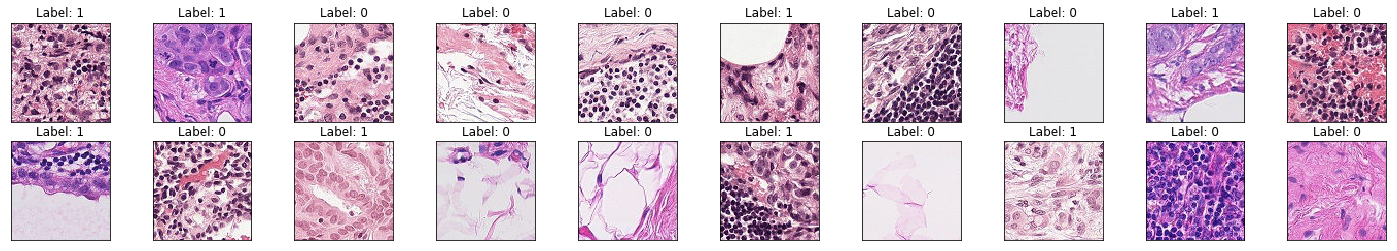

In [52]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx, img in enumerate(np.random.choice(train, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/train/" + img)
    plt.imshow(im)
    lab = data_labels.loc[data_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

Only by looking at the images above I can hardly tell why the images to the left were detected with no cancer. Maybe our model can find patterns that we cant. 

In [ ]:
img_class_dict = {k:v for k, v in zip(data_labels.id, data_labels.label)}

In [ ]:
tr, val = train_test_split(data_labels.label, stratify=data_labels.label, test_size=0.1)

Lets create a dataframe linking the path of the images to their labels

In [53]:
df = pd.DataFrame({'path': glob(os.path.join('../input/train/','*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
df = df.merge(data_labels, on = "id")
df.head()

,path,id,label
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b,0
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753,0
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98,0
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4,0
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d,0


In [54]:
df.size

660075

To avoid the kernel from crashing and balance the dataset, we will 5000 samples for each label(cancerous or not cancerous)

In [55]:
df0=df[df.label==0].sample(30000, random_state=42)
df1=df[df.label==1].sample(30000, random_state=42)
df_train = pd.concat([df0, df1], ignore_index=True).reset_index()
df_train = df_train[["path", "id", "label"]]
df_train.head()

,path,id,label
0,../input/train/abc45fa8fdafd6e104d30ccf69145ae...,abc45fa8fdafd6e104d30ccf69145ae57e5f637d,0
1,../input/train/772058c6148555b05d9a79bb289aec3...,772058c6148555b05d9a79bb289aec36ed7f1c2f,0
2,../input/train/ad1c1d2dee966a482fda97df084d634...,ad1c1d2dee966a482fda97df084d6349d8435596,0
3,../input/train/da344e4f84ffa399b2bdfb3146ee13e...,da344e4f84ffa399b2bdfb3146ee13e5061402c2,0
4,../input/train/b6919cb6cdb2ba3a1ad4941f9bcfa17...,b6919cb6cdb2ba3a1ad4941f9bcfa171c9a7c27d,0


Now,we have balanced the dataset having both 30000 cases where the images dectected cancer and another 5000 cases when there's no cancer. But lets create a column to get represent the images in arrays.

In [56]:
df_train['image']=df_train.path.map(imread)
df_train.head()

,path,id,label,image
0,../input/train/abc45fa8fdafd6e104d30ccf69145ae...,abc45fa8fdafd6e104d30ccf69145ae57e5f637d,0,"[[[230, 184, 212], [237, 195, 219], [204, 167,..."
1,../input/train/772058c6148555b05d9a79bb289aec3...,772058c6148555b05d9a79bb289aec36ed7f1c2f,0,"[[[207, 168, 189], [206, 167, 188], [204, 167,..."
2,../input/train/ad1c1d2dee966a482fda97df084d634...,ad1c1d2dee966a482fda97df084d6349d8435596,0,"[[[39, 3, 77], [68, 34, 94], [99, 63, 111], [5..."
3,../input/train/da344e4f84ffa399b2bdfb3146ee13e...,da344e4f84ffa399b2bdfb3146ee13e5061402c2,0,"[[[228, 223, 230], [225, 224, 229], [221, 225,..."
4,../input/train/b6919cb6cdb2ba3a1ad4941f9bcfa17...,b6919cb6cdb2ba3a1ad4941f9bcfa171c9a7c27d,0,"[[[206, 179, 184], [220, 189, 197], [119, 78, ..."


Let's create our set of inputs. we will create a 4-rank tensor: 60000 observations where each one is a 96x96x3 image.

In [57]:
input_images=np.stack(list(df_train.image),axis=0)
input_images.shape

(60000, 96, 96, 3)

Next, we will split our images into training set, testing set and validation set afterwards, we will run it through our model.

In [58]:
encoder=LabelBinarizer()
x=input_images
y=encoder.fit_transform(df_train.label)

train_X,test_X,train_Y,test_Y= train_test_split(x,y,train_size=0.8,random_state=42)

val_size = int(0.5*len(test_X))

val_tensors = test_X[:val_size]
val_targets = test_Y[:val_size]
test_tensors = test_X[val_size:]
test_targets = test_Y[val_size:]

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [59]:
set_random_seed(42)

early_stopping=EarlyStopping(monitor="val_loss", patience=5)
checkpointer=ModelCheckpoint(filepath="weights.hdf5",verbose=1,save_best_only=True)
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',input_shape=(96,96,3)))

model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))



In [60]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
epochs=15
model.fit(train_X,train_Y,validation_data=(val_tensors,val_targets),
          epochs=epochs,batch_size=80,verbose=1,callbacks=[early_stopping,checkpointer])

Train on 48000 samples, validate on 6000 samples
Epoch 1/15
48000/48000 [==============================] - 1246s 26ms/step - loss: 0.5732 - acc: 0.6955 - val_loss: 0.4880 - val_acc: 0.7997

Epoch 00001: val_loss improved from inf to 0.48796, saving model to weights.hdf5
Epoch 2/15
48000/48000 [==============================] - 1242s 26ms/step - loss: 0.4548 - acc: 0.7917 - val_loss: 0.4562 - val_acc: 0.8068

Epoch 00002: val_loss improved from 0.48796 to 0.45618, saving model to weights.hdf5
Epoch 3/15
48000/48000 [==============================] - 1245s 26ms/step - loss: 0.4327 - acc: 0.8048 - val_loss: 0.4346 - val_acc: 0.8007

Epoch 00003: val_loss improved from 0.45618 to 0.43459, saving model to weights.hdf5
Epoch 4/15
48000/48000 [==============================] - 1245s 26ms/step - loss: 0.4199 - acc: 0.8100 - val_loss: 0.4003 - val_acc: 0.8307

Epoch 00004: val_loss improved from 0.43459 to 0.40033, saving model to weights.hdf5
Epoch 5/15
48000/48000 [===========================

In [68]:
#show_final_history(history)
print("Validation Accuracy: " + str(model.history.history['val_acc'][-1:]))

Validation Accuracy: [0.887333333492279]


In [83]:
def final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(17,7))
    ax[0].set_title('Training Loss and Validation Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Training Accuracy and Validation Loss')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

****Visaulizing the Training and Validation Loss/Accuraccy****

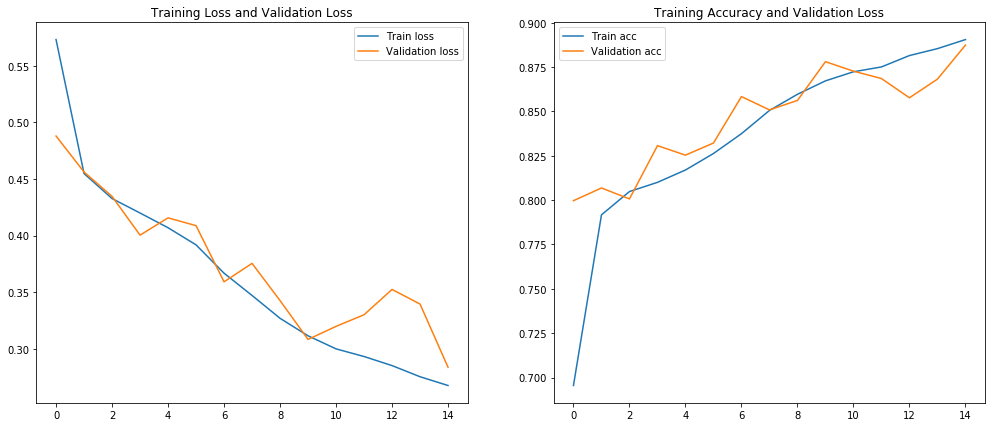

In [84]:
final_history(model.history)

In [90]:
test_prediction=model.predict_classes(test_tensors)

Lets see how well, it can predict unseen data i.e test_tensors, using the weight

In [97]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(test_prediction.astype('int32'), test_targets)*100
print('Test accuracy: %.4f%%' % score)

Test accuracy: 88.8576%


The net accuracy with this kernel is around 90% which is okay for the model. we were able to correctly classify around 5400 out of 6000 images.